# AI4IA Hackathon Phase 1: présentation du DataSet et exemple.s de prédiction

# Description:

Ce Notebook est mis à disposition des candidats du Challenge AI4IA-1ere Edition et est exclusivement dédié à cet évènement.

Le but de cet exemple classique est d'aider à la compréhension de ce qui est attendu des candidats, d'introduire les outils mis à disposition ainsi que les jeux de données et leur format. 

Les éléments fournis sont les suivants:
- jeu de données d'exemple (./data/DataSet_ex) sous la forme de plusieurs fichiers .csv, chacun correspondant à un signal d'excitation ;
- fichiers de définition des modèles et de leurs interfaces (cf. model_api.py et les exemples my_model1.py / my_model2.py). Note: le fichier de définition des modèles est la principale soumission des candidats: c'est à ce niveau qu'il est demandé d'implémenter l'architecture du modèle, ainsi que les stratégies d'inférence et d'entrainement;
- script générique pour le lancement d'un entraînement sur une instance AWS via sagemaker ou en local (sagemajer_api.py);
- scripts génériques pour l'évaluation des performances du modèle sur une instance AWS via sagemaker ou en local telles que définies pas les évaluateurs (les mêmes critères d'évaluation/métriques seront appliquées durant la phase d'évalutation, en considérant un jeu de données identique pour chaque candidat ainsi qu'une machine/instance AWS identique);
- une classe de test unitaire (cf. test_submission.py) permettant à tout instant de tester si la solution développée (la définition du modèle notamment) est conforme à ce qui est attendu et à ce qui sera mis en oeuvre lors de la phase d'évaluation. 

Note: il est donc indispensable que le modèle soumis par l'équipe candidate valide tous les tests unitaires et présente les caractéristiques nécessaires à l'évaluation de ses performances sur des instances AWS avec un fichier de test csv arbitraire (via calc_metrics_on_sagemaker.py). Il est donc vivement recommandé de s'assurer que le modèle développé présente bien ces caractéristiques.

Author: François Caire \
Maintainer: François Caire \
Email: francois.caire at skf.com 

# Sommaire :
1. [Chargement des Modules](#1-bullet)
2. [Chargement et exploration du DataSet](#2-bullet)
3. [Exemple Rudimentaire d'apprentissage](#3-bullet)
4. [Entraînement sur AWS SageMaker](#4-bullet)
5. [Evaluation de la solution en local et AWS SageMaker](#5-bullet)

# 1. Chargement des Modules <a class="anchor" id="1-bullet"></a>

Ici on importe les modules classiques

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
from scipy import signal as sg
from scipy import integrate
from scipy.interpolate import interpn,interp1d,RegularGridInterpolator, Akima1DInterpolator

import time
from tqdm import notebook
import importlib

import torch
from torch.utils.data import TensorDataset, DataLoader

import tarfile

%aimport -sg -mpl -plt -notebook -np -integrate -torch -TensorDataset -DataLoader

%matplotlib inline

On ajoute des paramètres d'affichage et de tracé...

In [2]:
font = {'family' : 'sans-serif',
        'weight' : 'bold',
        'size'   : 18}

mpl.rc('font', **font)
mpl.rcParams['lines.linewidth'] = 2.0

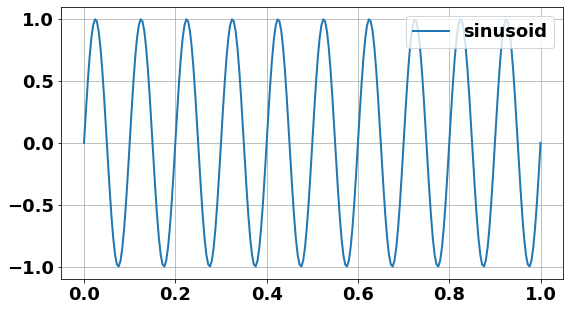

In [3]:
t=np.linspace(0,1,251)
y=np.sin(t*10*2*np.pi)

plt.figure(figsize=(9,5))
plt.plot(t,y,label='sinusoid')
plt.legend(loc='upper right')
plt.grid()
plt.show()


# 2. Chargement et Exploration/Tracé du DataSet d'exemple <a class="anchor" id="2-bullet"></a>

In [4]:
rep_data = "./data/DataSet_ex/"
names = ["input"+str(k) for k in range(1,6)]

d = {}
for name in names:
    d[name] = pd.read_csv(rep_data + name + '.csv',sep=',',index_col=False)

In [5]:
d['input1'].head()

,Time,input,output1,output2,output3,output4,output5
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,0.014892,0.0,0.0,0.0,0.0,0.0,0.0
2,0.029784,0.0,0.0,0.0,0.0,0.0,0.0
3,0.044676,0.0,0.0,0.0,0.0,0.0,0.0
4,0.059568,0.0,0.0,0.0,0.0,0.0,0.0


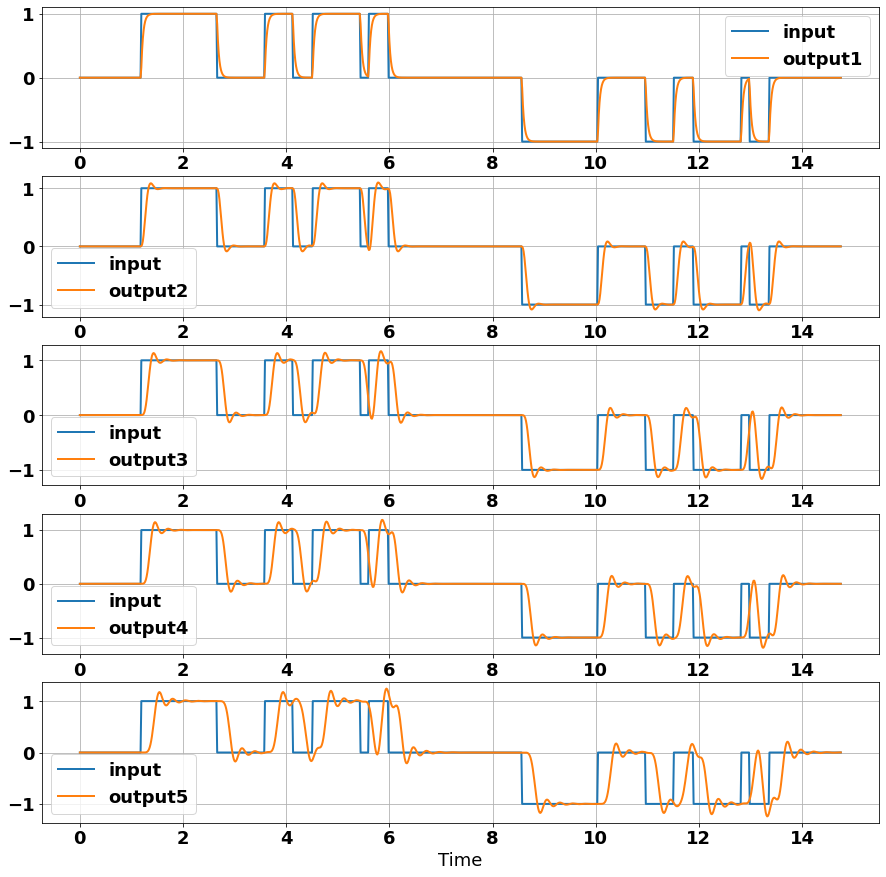

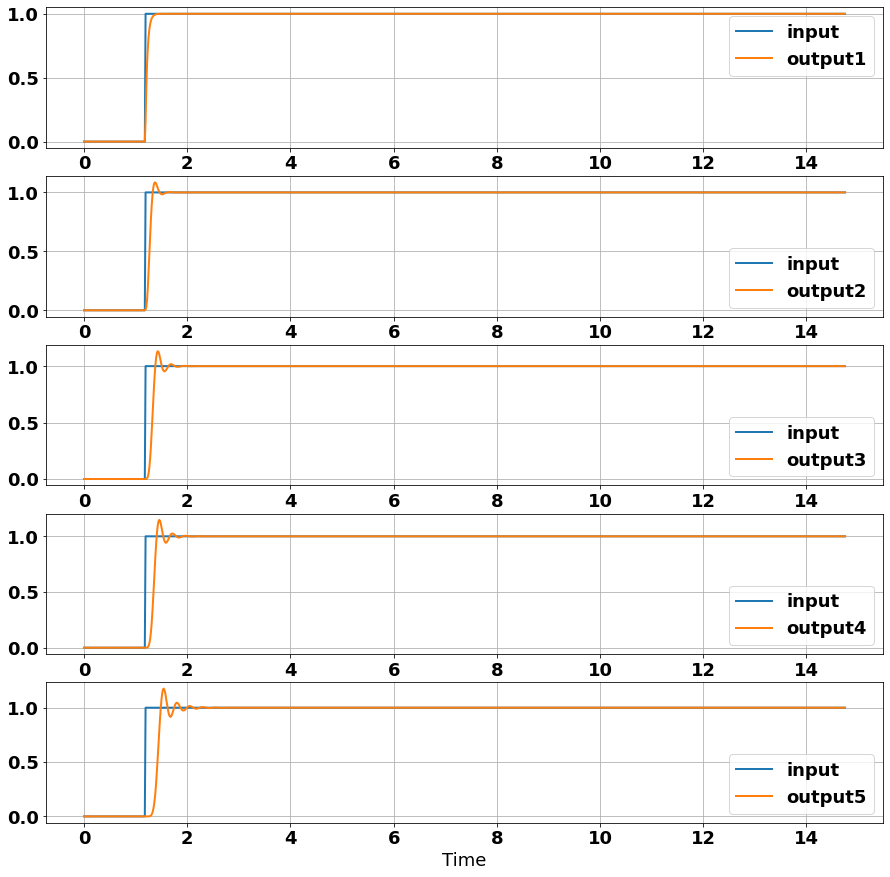

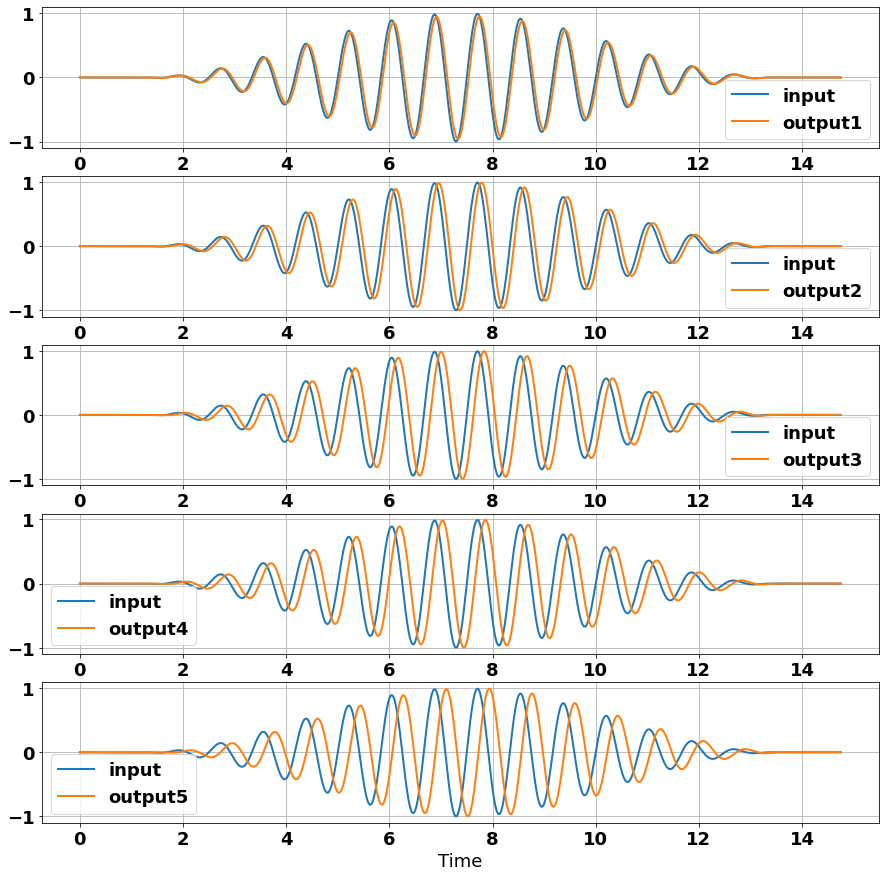

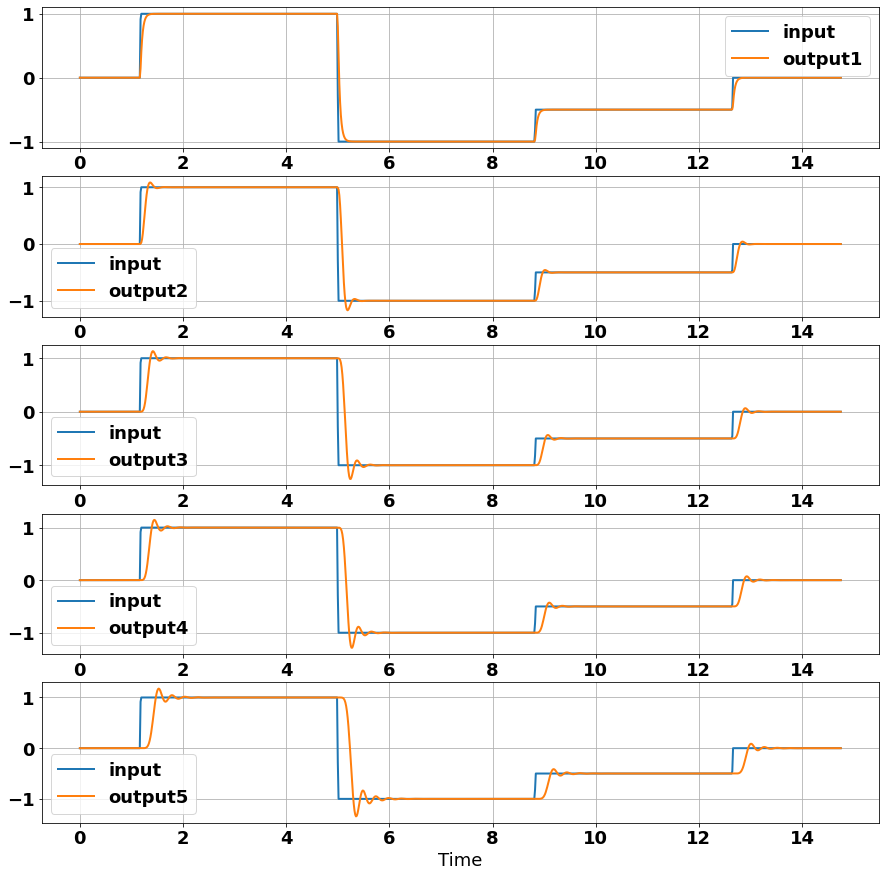

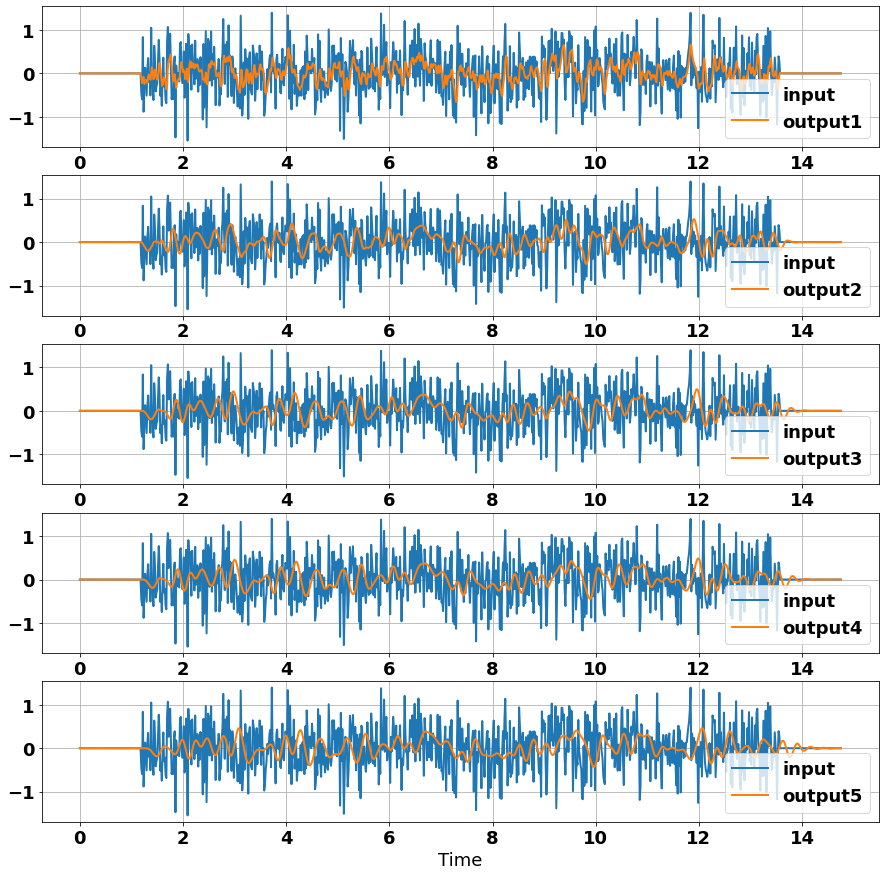

In [6]:
N_input   = 1
N_outputs = 5
N_signals = len(names)

for name in names:
    fig,ax = plt.subplots(N_outputs,1,figsize=(15,15))
    for k in range(N_outputs):
        d[name].plot(ax=ax[k],x='Time',y=[1,k+2],grid='on')


In [7]:
from sources.utilities.utility_functions import *

t,x,y = load_data_csv("data/DataSet_ex/input1.csv")

# 3. Exemple rudimentaire d'apprentissage <a class="anchor" id="3-bullet"></a>

0. Chargement des modules d'intérêt

In [8]:
import sys
from importlib import reload,import_module
import os

import sagemaker
import boto3

1. On charge ici le modele créé specifiquement

In [20]:
model_definition = "my_model2"

MyModel = import_module('sources.utilities.' + model_definition).MyModel

On peut vérifier grâce aux tests unitaire que le modele est valide pour soumission (NB: il doit calculer cinq sorties pour les cinq grandeurs d'intérêt)

In [10]:
if sys.platform == "win32":
    !python sources/utilities/test_submission.py my_model1
    !python sources/utilities/test_submission.py my_model2
else:
    !python3 sources/utilities/test_submission.py my_model1
    !python3 sources/utilities/test_submission.py my_model2

it. 0 / 25 - loss = 0.00243782
it. 1 / 25 - loss = 0.00099530
it. 2 / 25 - loss = 0.00031333
it. 3 / 25 - loss = 0.00023273
it. 4 / 25 - loss = 0.00045512
it. 5 / 25 - loss = 0.00062862
it. 6 / 25 - loss = 0.00062153
it. 7 / 25 - loss = 0.00049023
it. 8 / 25 - loss = 0.00033129
it. 9 / 25 - loss = 0.00019581
it. 10 / 25 - loss = 0.00011161
it. 11 / 25 - loss = 0.00008168
it. 12 / 25 - loss = 0.00009258
it. 13 / 25 - loss = 0.00012343
it. 14 / 25 - loss = 0.00015410
it. 15 / 25 - loss = 0.00017107
it. 16 / 25 - loss = 0.00016923
it. 17 / 25 - loss = 0.00015097
it. 18 / 25 - loss = 0.00012189
it. 19 / 25 - loss = 0.00009076
it. 20 / 25 - loss = 0.00006247
it. 21 / 25 - loss = 0.00004178
it. 22 / 25 - loss = 0.00003078
it. 23 / 25 - loss = 0.00002880
it. 24 / 25 - loss = 0.00003317
Model Description : 
{'affiliation': 'SKF Group',
 'description': 'This is a simple GRU model that supports 1 input and 1 to 5 '
                'outputs',
 'email': 'francois.caire@skf.com',
 'model_name': 'GR

C:\Users\lixia\Documents\esiee\E5\Time series\AI4IA_phase1_python\sources\utilities\my_model1.py:75: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ..\torch\csrc\utils\tensor_new.cpp:201.)
  y = torch.tensor(ys,dtype=float).view(x.shape[0],-1)
.
----------------------------------------------------------------------
Ran 1 test in 0.094s

OK


it. 0 / 25 - loss = 0.00447696
it. 1 / 25 - loss = 0.00437361
it. 2 / 25 - loss = 0.00423361
it. 3 / 25 - loss = 0.00407523
it. 4 / 25 - loss = 0.00390935
it. 5 / 25 - loss = 0.00374232
it. 6 / 25 - loss = 0.00357776
it. 7 / 25 - loss = 0.00341769
it. 8 / 25 - loss = 0.00326316
it. 9 / 25 - loss = 0.00311466
it. 10 / 25 - loss = 0.00297235
it. 11 / 25 - loss = 0.00283621
it. 12 / 25 - loss = 0.00270611
it. 13 / 25 - loss = 0.00258185
it. 14 / 25 - loss = 0.00246324
it. 15 / 25 - loss = 0.00235003
it. 16 / 25 - loss = 0.00224200
it. 17 / 25 - loss = 0.00213892
it. 18 / 25 - loss = 0.00204057
it. 19 / 25 - loss = 0.00194674
it. 20 / 25 - loss = 0.00185721
it. 21 / 25 - loss = 0.00177180
it. 22 / 25 - loss = 0.00169032
it. 23 / 25 - loss = 0.00161258
it. 24 / 25 - loss = 0.00153842
Model Description : 
{'affiliation': 'SKF Group',
 'description': 'This is a simple GRU model that supports 1 input and 1 to 5 '
                'outputs',
 'email': 'francois.caire@skf.com',
 'model_name': 'GR

C:\Users\lixia\Documents\esiee\E5\Time series\AI4IA_phase1_python\sources\utilities\my_model2.py:86: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ..\torch\csrc\utils\tensor_new.cpp:201.)
  y = torch.tensor(ys,dtype=float).view(x.shape[0],-1)
.
----------------------------------------------------------------------
Ran 1 test in 0.157s

OK


In [11]:
if sys.platform == 'linux':
    !pygmentize "./sources/utilities/my_model2.py"

2. On selectionne le/les signaux utiles pour l'apprentissage et ceux pour la validation:

In [12]:
rep_data   = "data/DataSet_ex/"
file_train = "input4.csv"

t_train,x_train,y_train = load_data_csv(rep_data+file_train)

In [13]:
retrain = True

C:\Users\lixia\Documents\esiee\E5\Time series\AI4IA_phase1_python\sources\utilities\my_model2.py:86: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ..\torch\csrc\utils\tensor_new.cpp:201.)
  y = torch.tensor(ys,dtype=float).view(x.shape[0],-1)


it. 0 / 150 - loss = 0.05220643
it. 6 / 150 - loss = 0.01635426
it. 12 / 150 - loss = 0.00996137
it. 18 / 150 - loss = 0.00434079
it. 24 / 150 - loss = 0.00343592
it. 30 / 150 - loss = 0.00315703
it. 36 / 150 - loss = 0.00299173
it. 42 / 150 - loss = 0.00291084
it. 48 / 150 - loss = 0.00286531
it. 54 / 150 - loss = 0.00283867
it. 60 / 150 - loss = 0.00282293
it. 66 / 150 - loss = 0.00281367
it. 72 / 150 - loss = 0.00280772
it. 78 / 150 - loss = 0.00280203
it. 84 / 150 - loss = 0.00279634
it. 90 / 150 - loss = 0.00279069
it. 96 / 150 - loss = 0.00278510
it. 102 / 150 - loss = 0.00277951
it. 108 / 150 - loss = 0.00277399
it. 114 / 150 - loss = 0.00276850
it. 120 / 150 - loss = 0.00276305
it. 126 / 150 - loss = 0.00275763
it. 132 / 150 - loss = 0.00275225
it. 138 / 150 - loss = 0.00274689
it. 144 / 150 - loss = 0.00274158


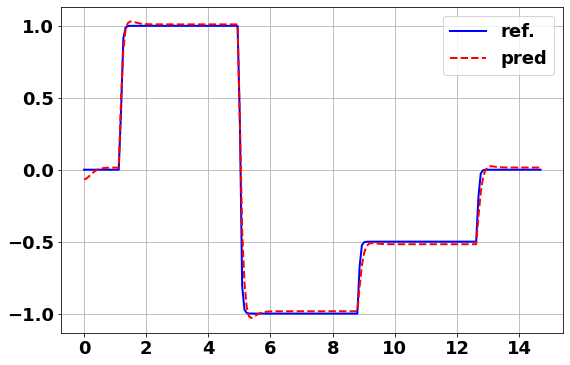

In [14]:
if retrain:
    Ndecim=5
    outputs_indexes = [0]
    model = MyModel.create_model(torch.cuda.is_available(), epochs=150, lr=0.05, output_size = len(outputs_indexes))

    model.fit(xs=[x_train[::Ndecim]],ys=[y_train[::Ndecim,k] for k in outputs_indexes])
    
    retrain = False

y_pred_train = model.predict_timeseries(x_train[::Ndecim])
for k in range(len(outputs_indexes)):
    fig,ax = plt.subplots(1,1,figsize=(9,6))
    ax.plot(t_train[::Ndecim],y_train[::Ndecim,outputs_indexes[k]],'b',t_train[::Ndecim],y_pred_train[:,k],'--r') 
    plt.grid()
    plt.legend(["ref.","pred"])

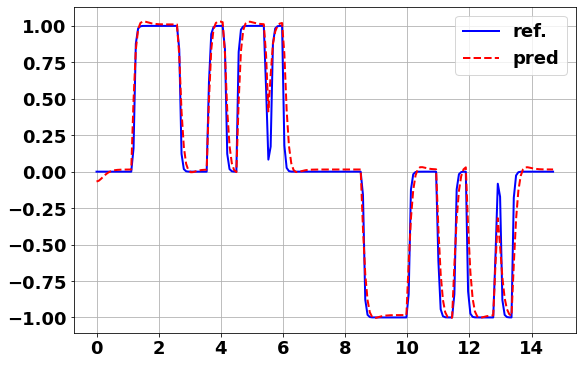

In [15]:
file_test  = "input1.csv"
t_test,x_test,y_test = load_data_csv(rep_data+file_test)

y_pred = model.predict_timeseries(x_test[::Ndecim])

for k in range(len(outputs_indexes)):
    fig,ax = plt.subplots(1,1,figsize=(9,6))
    ax.plot(t_test[::Ndecim],y_test[::Ndecim,outputs_indexes[k]],'b',t_test[::Ndecim],y_pred[:,k],'--r') 
    plt.grid()
    plt.legend(["ref.","pred"])

# 4. Lancement sur AWS SageMaker <a class="anchor" id="4-bullet"></a>

0. Test local

Permet de vérifier que tout est ok avant de monter l'image sur une instance amazon (ce qui peut être long)

In [21]:
rep = "data/DataSet_ex/"
file_train = "input4.csv"
data = rep + file_train

use_gpu = True
epochs = 40
model_dir = "./models"
model_name = "model0"
lr = 0.05
Ndecim = 5
outputs_indexes = [0,1]
outputs_ind = ','.join([str(k+1) for k in outputs_indexes])
hyper_fileName = "hyper.json"
outputs_prefix='output'

%run sources/sagemaker_api.py --use_gpu $use_gpu --lr $lr --epochs $epochs \
                              --data_dir $rep --train_fileName $file_train --model_dir $model_dir \
                              --outputs_indexes $outputs_ind --Ndecim $Ndecim --hyper_fileName $hyper_fileName\
                              --model_def_file $model_definition --outputs_prefix $outputs_prefix


Failed to load default container env keys. Using local default keys.
it. 0 / 40 - loss = 0.16073886
it. 1 / 40 - loss = 0.09110543
it. 2 / 40 - loss = 0.08484031
it. 3 / 40 - loss = 0.11271312
it. 4 / 40 - loss = 0.12777424
it. 5 / 40 - loss = 0.11580016
it. 6 / 40 - loss = 0.10321285
it. 7 / 40 - loss = 0.10180061
it. 8 / 40 - loss = 0.10726897
it. 9 / 40 - loss = 0.11239786
it. 10 / 40 - loss = 0.11406983
it. 11 / 40 - loss = 0.11252438
it. 12 / 40 - loss = 0.11069449
it. 13 / 40 - loss = 0.11002193
it. 14 / 40 - loss = 0.10995041
it. 15 / 40 - loss = 0.11046545
it. 16 / 40 - loss = 0.11124440
it. 17 / 40 - loss = 0.11165696
it. 18 / 40 - loss = 0.11175845
it. 19 / 40 - loss = 0.11179837
it. 20 / 40 - loss = 0.11161800
it. 21 / 40 - loss = 0.11139645
it. 22 / 40 - loss = 0.11135211
it. 23 / 40 - loss = 0.11126765
it. 24 / 40 - loss = 0.11120947
it. 25 / 40 - loss = 0.11142000
it. 26 / 40 - loss = 0.11158065
it. 27 / 40 - loss = 0.11162803
it. 28 / 40 - loss = 0.11174837
it. 29 / 40 -

<Figure size 432x288 with 0 Axes>

In [22]:
t_train,x_train,y_train = load_data_csv(rep+file_train,Ndecim=Ndecim)
file_test  = "input3.csv"

In [23]:
model = MyModel.load(model_dir)

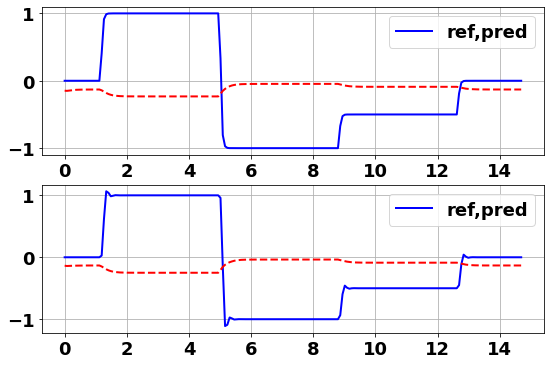

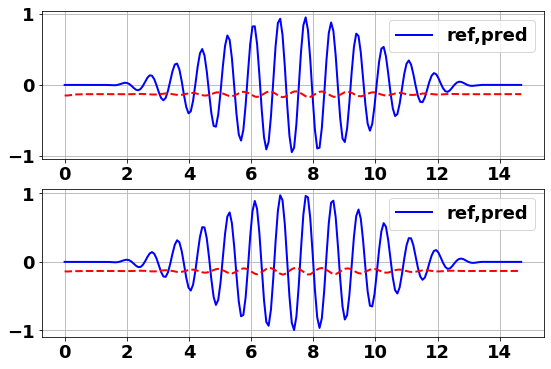

In [24]:
y_pred = model.predict_timeseries(x_train)

No = len(outputs_indexes)
fig,ax = plt.subplots(No,1,figsize=(9,3*No))
if No>1:
    for k in range(No):
        ax[k].plot(t_train,y_train[:,outputs_indexes[k]],'b',t_train,y_pred[:,k],'--r')
        ax[k].grid()
        ax[k].legend(['ref,pred'])
else:
    ax.plot(t_train,y_train[:,outputs_indexes[0]],'b',t_train,y_pred[:,0],'--r')
    ax.grid()
    ax.legend(['ref,pred'])
    
t_test,x_test,y_test = load_data_csv(rep+file_test,Ndecim=Ndecim)
y_pred = model.predict_timeseries(x_test)

fig,ax = plt.subplots(No,1,figsize=(9,3*No))
if No>1:
    for k in range(No):
        ax[k].plot(t_test,y_test[:,outputs_indexes[k]],'b',t_test,y_pred[:,k],'--r')
        ax[k].grid()
        ax[k].legend(['ref,pred'])
else:
    ax.plot(t_test,y_test[:,outputs_indexes[0]],'b',t_test,y_test[:,0],'--r')
    ax.grid()
    ax.legend(['ref,pred'])  
    
plt.show()


1. Depôt des données sur S3

In [25]:
sagemaker_session = sagemaker.Session()

bucket = sagemaker_session.default_bucket()
prefix_in  = 'DEMO-AI4IA/input'
prefix_out = 'DEMO-AI4IA/model'
role = "<your-role-number>"

ValueError: Must setup local AWS configuration with a region supported by SageMaker.

In [29]:
rep_data = './data/DataSet_ex/'

input_channel = sagemaker_session.upload_data(path=rep_data, bucket=bucket, key_prefix=prefix_in)
print('input file (in this case, just an S3 path): {}'.format(input_channel))


input file (in this case, just an S3 path): s3://sagemaker-eu-west-1-480368206057/DEMO-AI4IA/input


2. Creation des instances et paramétrage de l'estimateur:

In [30]:
output_path = f's3://'+bucket+'/'+prefix_out

outputs_indexes = [0]
outputs_ind = ','.join([str(k+1) for k in outputs_indexes])

In [31]:
model_name = 'model_GRU'
max_run = 60*60*6 # Max time in seconds

sagemaker_estimator,framework_version = model.get_sagemaker_estimator_class()
estimator = sagemaker_estimator(entry_point = 'sagemaker_api.py',
                                source_dir  = 'sources',
                                role = role,
                                py_version = 'py3',
                                max_run=max_run,
                                framework_version = framework_version,
                                instance_count = 1,
                                instance_type='ml.p3.2xlarge', #'ml.m4.xlarge',#'ml.p2.xlarge',#'ml.p3.2xlarge',#
                                output_path=f's3://'+bucket+'/'+prefix_out,
                                hyperparameters={
                                                    'use_gpu':True,
                                                    'epochs':350,
                                                    'lr':.05,
                                                    'outputs_indexes': outputs_ind,
                                                    'Ndecim':5,
                                                    'train_fileName':file_train,
                                                    'model_def_file':'my_model2',
                                                    'outputs_prefix':'output'
                                }
                               )

In [32]:
estimator.fit({'training': input_channel})

2021-10-27 09:28:58 Starting - Starting the training job...
2021-10-27 09:29:00 Starting - Launching requested ML instancesProfilerReport-1635326937: InProgress
......
2021-10-27 09:30:28 Starting - Preparing the instances for training.........
2021-10-27 09:31:51 Downloading - Downloading input data
2021-10-27 09:31:51 Training - Downloading the training image..................
2021-10-27 09:34:56 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2021-10-27 09:34:56,832 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2021-10-27 09:34:56,856 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2021-10-27 09:35:03,130 sagemaker_pytorch_container.training INFO     Invoking user training script.
2021-10-27 09:35:03,557 sagemaker-training-toolkit INFO     Invoking user script

Training

In [33]:
training_job_name = estimator.latest_training_job.name
desc = sagemaker_session.sagemaker_client.describe_training_job(TrainingJobName=training_job_name)
trained_model_location = desc['ModelArtifacts']['S3ModelArtifacts']
display('Model is here: {}'.format(trained_model_location))

s3 = boto3.resource('s3')    
s3.Bucket(bucket).download_file(prefix_out + '/' + desc['TrainingJobName'] + '/' + 'output/model.tar.gz','./models/model.tar.gz')

'Model is here: s3://sagemaker-eu-west-1-480368206057/DEMO-AI4IA/model/pytorch-training-2021-10-27-09-28-57-999/output/model.tar.gz'

In [34]:
model_dir = './models/model0'

with tarfile.open('./models/model.tar.gz','r:gz') as archived:
    archived.extractall(model_dir)

In [35]:
model = MyModel.load(model_dir)

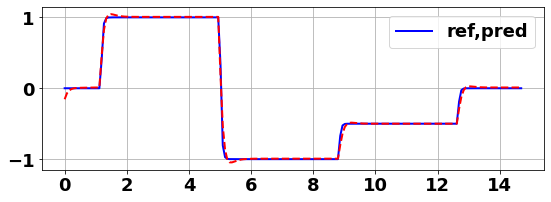

In [36]:
y_pred = model.predict_timeseries(x_train)

No = len(outputs_indexes)
fig,ax = plt.subplots(No,1,figsize=(9,3*No))
if No>1:
    for k in range(No):
        ax[k].plot(t_train,y_train[:,outputs_indexes[:,k]],'b',t_train,y_pred[:,k],'--r')
        ax[k].grid()
        ax[k].legend(['ref,pred'])
else:
    ax.plot(t_train,y_train[:,outputs_indexes[0]],'b',t_train,y_pred[:,0],'--r')
    ax.grid()
    ax.legend(['ref,pred'])


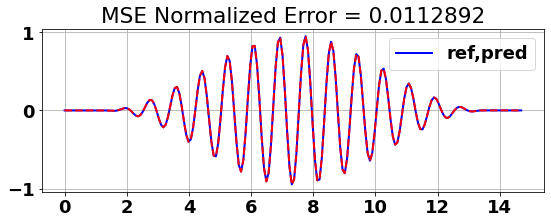

In [38]:
from sklearn.metrics import mean_squared_error


y_pred = model.predict_timeseries(x_test)
t_test,x_test,y_test = load_data_csv(rep+file_test,Ndecim=Ndecim)
max_ytest_value = np.zeros( (No,) )
for k in range(No) : # PLEASE NOTE THAT WE ONLY CONSIDER MODELS THAT COMPUTES ALL THE 5 OUTPUTS
    max_ytest_value[k] = np.max(np.abs(y_test[:,k]))

metric_normalized_mse = np.zeros( (No,) )
for k in range(No):
    metric_normalized_mse[k] = mean_squared_error(y_true=y_test[:,k]/max_ytest_value[k],y_pred=y_pred[:,k]/max_ytest_value[k])

fig,ax = plt.subplots(No,1,figsize=(9,3*No))
if No>1:
    for k in range(No):
        ax[k].plot(t_test,y_test[:,outputs_indexes[:,k]],'b',t_test,y_pred[:,k],'--r')
        ax[k].grid()
        ax[k].legend(['ref,pred'])
        ax[k].set_title("MSE Normalized Error = {:01.7f}".format(metric_normalized_mse[k]))
else:
    ax.plot(t_test,y_test[:,outputs_indexes[0]],'b',t_test,y_test[:,0],'--r')
    ax.grid()
    ax.legend(['ref,pred'])  
    ax.set_title("MSE Normalized Error = {:01.7f}".format(metric_normalized_mse[0]))
    
plt.show()

In [39]:
rep = "data/DataSet_ex/"
file_train = "input1.csv"
data = rep + file_train

use_gpu = True
epochs = 40
model_dir = "./models/model1"
model_name = "model0"
lr = 0.05
Ndecim = 5
outputs_indexes = [0,1,2,3,4]
outputs_ind = ','.join([str(k+1) for k in outputs_indexes])
hyper_fileName = "hyper.json"

%run sources/sagemaker_api.py --use_gpu $use_gpu --lr $lr --epochs $epochs \
                              --data_dir $rep --train_fileName $file_train --model_dir $model_dir \
                              --outputs_indexes $outputs_ind --Ndecim $Ndecim --hyper_fileName $hyper_fileName

Failed to load default container env keys. Using local default keys.
it. 0 / 40 - loss = 0.44143164
it. 1 / 40 - loss = 1.03846800
it. 2 / 40 - loss = 4.33085728
it. 3 / 40 - loss = 2.40181637
it. 4 / 40 - loss = 2.81796527
it. 5 / 40 - loss = 2.32328677
it. 6 / 40 - loss = 1.95544338
it. 7 / 40 - loss = 0.63925719
it. 8 / 40 - loss = 0.94174266
it. 9 / 40 - loss = 0.76548415
it. 10 / 40 - loss = 0.57130992
it. 11 / 40 - loss = 0.59065956
it. 12 / 40 - loss = 0.50133789
it. 13 / 40 - loss = 0.50669152
it. 14 / 40 - loss = 0.49210456
it. 15 / 40 - loss = 0.42784294
it. 16 / 40 - loss = 0.49803540
it. 17 / 40 - loss = 0.43792343
it. 18 / 40 - loss = 0.41676643
it. 19 / 40 - loss = 0.46375328
it. 20 / 40 - loss = 0.40950313
it. 21 / 40 - loss = 0.40337148
it. 22 / 40 - loss = 0.43332094
it. 23 / 40 - loss = 0.38606760
it. 24 / 40 - loss = 0.38573816
it. 25 / 40 - loss = 0.41319704
it. 26 / 40 - loss = 0.37295166
it. 27 / 40 - loss = 0.37878627
it. 28 / 40 - loss = 0.42095053
it. 29 / 40 -

<Figure size 432x288 with 0 Axes>

# 5. Evaluation des solutions <a class="anchor" id="5-bullet"></a>

0. Recuperation des paramètres (modele et entraînement)

In [40]:
with open("./models/model1/hyper.json","r") as f:
    dHyper = json.load(f)

with open("models/model1/model_kwargs.json","r") as f:
    dKwargs = json.load(f)

In [41]:
dHyper,dKwargs

({'model_dir': './models/model1',
  'data_dir': 'data/DataSet_ex/',
  'model_def_file': 'my_model1',
  'epochs': 40,
  'lr': 0.05,
  'outputs_indexes': '1,2,3,4,5',
  'hyper_fileName': 'hyper.json',
  'use_gpu': True,
  'train_fileName': 'input1.csv',
  'Ndecim': 5,
  'outputs_prefix': 'output'},
 {'device': 'cpu', 'epochs': 40, 'lr': 0.05, 'output_size': 5})

1. Local metric tests

In [42]:
model1 = MyModel(**dKwargs)

In [61]:
data_dir = "./data/DataSet_ex"
hyper_filename  = "hyper.json"
kwargs_filename = "model_kwargs.json"
test_filename   = 'input2.csv'
model_dir       = './models/model1'
model_def_file  = 'my_model2'

%run sources/calc_metrics.py --data_dir $data_dir \
                             --model_dir $model_dir \
                             --estimator_hyperParams_fileName $hyper_fileName \
                             --model_kwargs_fileName $kwargs_filename \
                             --test_fileName $test_filename \
                             --model_def_file $model_def_file


./models/model1\hyper.json
it. 0 / 40 - loss = 0.43867967
it. 1 / 40 - loss = 0.43239564
it. 2 / 40 - loss = 0.42850190
it. 3 / 40 - loss = 0.42396954
it. 4 / 40 - loss = 0.41799599
it. 5 / 40 - loss = 0.41136277
it. 6 / 40 - loss = 0.40454590
it. 7 / 40 - loss = 0.39754105
it. 8 / 40 - loss = 0.39074364
it. 9 / 40 - loss = 0.38508815
it. 10 / 40 - loss = 0.38071904
it. 11 / 40 - loss = 0.37741965
it. 12 / 40 - loss = 0.37516290
it. 13 / 40 - loss = 0.37311348
it. 14 / 40 - loss = 0.37102935
it. 15 / 40 - loss = 0.36984864
it. 16 / 40 - loss = 0.36906853
it. 17 / 40 - loss = 0.36831897
it. 18 / 40 - loss = 0.36753970
it. 19 / 40 - loss = 0.36673939
it. 20 / 40 - loss = 0.36610690
it. 21 / 40 - loss = 0.36554047
it. 22 / 40 - loss = 0.36493698
it. 23 / 40 - loss = 0.36453789
it. 24 / 40 - loss = 0.36412829
it. 25 / 40 - loss = 0.36367548
it. 26 / 40 - loss = 0.36320129
it. 27 / 40 - loss = 0.36273584
it. 28 / 40 - loss = 0.36222801
it. 29 / 40 - loss = 0.36174682
it. 30 / 40 - loss = 0.

In [62]:
with open('./metrics/s2m_GRU2_metrics','r') as f: print(f.read())

affiliation : SKF Group
description : This is a simple GRU model that supports 1 input and 1 to 5 outputs
email : francois.caire@skf.com
model_name : GRU2
other_remarks : 
team_name : s2m
technology_stack : pytorch
Aggregated Metrics : 6.955048664677872
Average inference time [seconds] : 0.0011759936809539796
Entire series inference time [seconds] : 1.1759936809539795
Maximal inference time [seconds] : 0.0030090808868408203
Normalized MSE : [1.68015322 1.44202945 1.33548981 1.28798675 1.20500119]
Normalized MSE Sum : 6.950660429795583
Training set size : 200
Training time [seconds] : 11.377132177352905



In [63]:
pwd

'C:\\Users\\CAIRE\\Documents\\Virtual Machines\\shared\\hackathon\\api_sagemaker_final\\AI4IA_phase1_python'

2. AWS Metrics tests

In [50]:
metrics_dir = './metrics_sage'
model_def_file = "my_model1"
type_instance = 'ml.m5.xlarge' # Mention that the time limit is t on this specific type of instance

%run calc_metrics_on_sagemaker.py --data_dir $data_dir \
                                  --model_dir $model_dir \
                                  --role $role \
                                  --estimator_hyperParams_fileName $hyper_fileName \
                                  --model_kwargs_fileName $kwargs_filename \
                                  --test_fileName $test_filename \
                                  --out_dir $metrics_dir \
                                  --model_def_file $model_def_file

2021-10-27 09:48:22 Starting - Starting the training job...
2021-10-27 09:48:45 Starting - Launching requested ML instancesProfilerReport-1635328101: InProgress
...
2021-10-27 09:49:16 Starting - Preparing the instances for training............
2021-10-27 09:51:06 Downloading - Downloading input data...
2021-10-27 09:51:46 Training - Downloading the training image.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2021-10-27 09:51:58,202 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2021-10-27 09:51:58,205 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2021-10-27 09:51:58,218 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2021-10-27 09:51:58,865 sagemaker_pytorch_container.training INFO     Invoking user training script.
2021-10-27 09:51:59,277 sagemaker-training-toolkit INFO     No GPUs detected (normal 

In [55]:
with open(os.path.join(metrics_dir,'s2m' '_' + 'GRU1' + '_metrics'),'r') as f:  print(f.read())

affiliation : SKF Group
description : This is a simple GRU model that supports 1 input and 1 to 5 outputs
email : francois.caire@skf.com
model_name : GRU1
other_remarks : 
team_name : s2m
technology_stack : pytorch
Aggregated Metrics : 3.0958937816105667
Average inference time [seconds] : 0.0009050564765930175
Entire series inference time [seconds] : 0.9050564765930176
Maximal inference time [seconds] : 0.004453420639038086
Normalized MSE : [0.36984636 0.62093299 0.64192965 0.86716029 0.59066486]
Normalized MSE Sum : 3.0905341448453783
Training time [seconds] : 4.17473840713501



In [52]:
metrics_dir = './metrics_sage'
model_def_file = "my_model2"

%run calc_metrics_on_sagemaker.py --data_dir $data_dir \
                                  --model_dir $model_dir \
                                  --role $role \
                                  --estimator_hyperParams_fileName $hyper_fileName \
                                  --model_kwargs_fileName $kwargs_filename \
                                  --test_fileName $test_filename \
                                  --out_dir $metrics_dir \
                                  --model_def_file $model_def_file

2021-10-27 09:53:07 Starting - Starting the training job...
2021-10-27 09:53:30 Starting - Launching requested ML instancesProfilerReport-1635328386: InProgress
......
2021-10-27 09:54:33 Starting - Preparing the instances for training.........
2021-10-27 09:55:51 Downloading - Downloading input data...
2021-10-27 09:56:31 Training - Downloading the training image..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2021-10-27 09:56:49,518 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2021-10-27 09:56:49,521 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2021-10-27 09:56:49,534 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.

2021-10-27 09:57:09 Uploading - Uploading generated training model2021-10-27 09:56:55,759 sagemaker_pytorch_container.training INFO     Invoking user training script.
2021-10-27 09:56:

In [56]:
with open(os.path.join(metrics_dir,'s2m' '_' + 'GRU2' + '_metrics'),'r') as f:  print(f.read())

affiliation : SKF Group
description : This is a simple GRU model that supports 1 input and 1 to 5 outputs
email : francois.caire@skf.com
model_name : GRU2
other_remarks : 
team_name : s2m
technology_stack : pytorch
Aggregated Metrics : 6.881637116049163
Average inference time [seconds] : 0.0009189200401306152
Entire series inference time [seconds] : 0.9189200401306152
Maximal inference time [seconds] : 0.001825094223022461
Normalized MSE : [1.67763833 1.40341474 1.30848855 1.28328809 1.20606159]
Normalized MSE Sum : 6.87889129578236
Training time [seconds] : 6.501613140106201



In [58]:
if sys.platform=='linux':
    !pipreqs ./ --force